*Read section 4.7.6 of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.35)

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, KFold, RepeatedKFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.metrics import root_mean_squared_error, r2_score

## KNN for regression

In [2]:
# Load the dataset
car = pd.read_csv('Datasets/car.csv')

# Split the dataset into features and target variable
X = car.drop(columns=['price'])
y = car['price']

# split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# extract the categorical columns and put them in a list
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# extract the numerical columns and put them in a list
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [4]:
# First transform categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),  # Just pass numerical features through
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])

# Create pipeline that scales all features together
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),  # Scale everything together
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)
# Predict on the test data
y_pred = pipeline.predict(X_test)
# Calculate RMSE
rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {pipeline.score(X_test, y_test):.2f}")

RMSE: 4364.84
R² Score: 0.94


In [5]:
# show the features in the numerical transformer    
pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
print("numerical features in the pipeline:", pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out())

# show the features in the categorical transformer
pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()
print("categorical features in the pipeline:", pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())

numerical features in the pipeline: ['year' 'mileage' 'tax' 'mpg' 'engineSize']
categorical features in the pipeline: ['brand_audi' 'brand_bmw' 'brand_ford' 'brand_hyundi' 'brand_merc'
 'brand_skoda' 'brand_toyota' 'brand_vauxhall' 'brand_vw'
 'model_ 6 Series' 'model_ 7 Series' 'model_ 8 Series' 'model_ A7'
 'model_ A8' 'model_ Agila' 'model_ Amarok' 'model_ Antara'
 'model_ Arteon' 'model_ Avensis' 'model_ Beetle' 'model_ CC'
 'model_ CLA Class' 'model_ CLK' 'model_ CLS Class' 'model_ Caddy'
 'model_ Caddy Life' 'model_ Caddy Maxi Life' 'model_ California'
 'model_ Camry' 'model_ Caravelle' 'model_ Combo Life' 'model_ Edge'
 'model_ Eos' 'model_ Fusion' 'model_ G Class' 'model_ GL Class'
 'model_ GLB Class' 'model_ GLS Class' 'model_ GT86' 'model_ GTC'
 'model_ Galaxy' 'model_ Getz' 'model_ Grand C-MAX'
 'model_ Grand Tourneo Connect' 'model_ Hilux' 'model_ I40' 'model_ I800'
 'model_ IQ' 'model_ IX20' 'model_ IX35' 'model_ Jetta' 'model_ KA'
 'model_ Kamiq' 'model_ Land Cruiser' 'mo

## Feature Scaling in KNN

**Feature scaling is essential when using K-Nearest Neighbors (KNN)** because the algorithm relies on calculating distances between data points. If features are measured on different scales (e.g., `mileage` in thousands and `mpg` in tens), the features with larger numeric ranges can dominate the distance calculations and distort the results.

To ensure that all features contribute equally, it’s important to **standardize or normalize** them before applying KNN. Common scaling techniques include:

- **Standardization** (zero mean, unit variance) using `StandardScaler`
- **Min-max scaling** to bring values into the `[0, 1]` range

Without scaling, KNN may produce biased or misleading predictions.  
The example below illustrates how the same KNN model performs **without feature scaling**, highlighting the importance of preprocessing your data.


In [6]:
preprocessor_no_scaling = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),  # Pass numerical features through without scaling
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)  # Only one-hot encode categorical
    ])

# Create pipeline without any scaling
pipeline_no_scaling = Pipeline(steps=[
    ('preprocessor', preprocessor_no_scaling),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# Fit the pipeline
pipeline_no_scaling.fit(X_train, y_train)

# Evaluate
y_pred_no_scaling = pipeline_no_scaling.predict(X_test)

rmse_no_scaling = root_mean_squared_error(y_test, y_pred_no_scaling)
print(f"RMSE without scaling: {rmse_no_scaling:.2f}")
print(f"R² Score without scaling: {pipeline_no_scaling.score(X_test, y_test):.2f}")

RMSE without scaling: 13758.38
R² Score without scaling: 0.35


## Hyperparameters in KNN

The most important hyperparameter in K-Nearest Neighbors (KNN) is **_k_**, which determines the number of neighbors considered when making predictions. Tuning _k_ helps balance the model’s **bias and variance**:

- A **small _k_** (e.g., 1 or 3) can lead to **low bias but high variance**, making the model sensitive to noise in the training data.
- A **large _k_** results in **higher bias but lower variance**, producing smoother predictions that may underfit the data.

### Tuning _k_ in KNN

To find the optimal value of _k_, it's common to use **cross-validation**, which evaluates model performance on different subsets of the data. A popular tool for this is **`GridSearchCV`**, which automates the search process by testing multiple values of _k_ using cross-validation behind the scenes. It selects the value of _k_ that minimizes prediction error on unseen data—helping you achieve a good balance between underfitting and overfitting.


In [7]:
# Create parameter grid for k values
param_grid = {
    'knn__n_neighbors': list(range(1, 20))  # Test k values from 1 to 20
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',  # Optimize for RMSE
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit grid search
print("Tuning k parameter...")
grid_search.fit(X_train, y_train)

# Get best parameters and results
best_k = grid_search.best_params_['knn__n_neighbors']
best_score = -grid_search.best_score_  # Convert back from negative RMSE

print(f"Best k: {best_k}")
print(f"Best CV RMSE: {best_score:.2f}")

# Evaluate on test set using best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test RMSE with k={best_k}: {test_rmse:.2f}")
print(f"Test R² Score with k={best_k}: {test_r2:.2f}")

Tuning k parameter...
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best k: 3
Best CV RMSE: 4117.42
Test RMSE with k=3: 4051.06
Test R² Score with k=3: 0.94


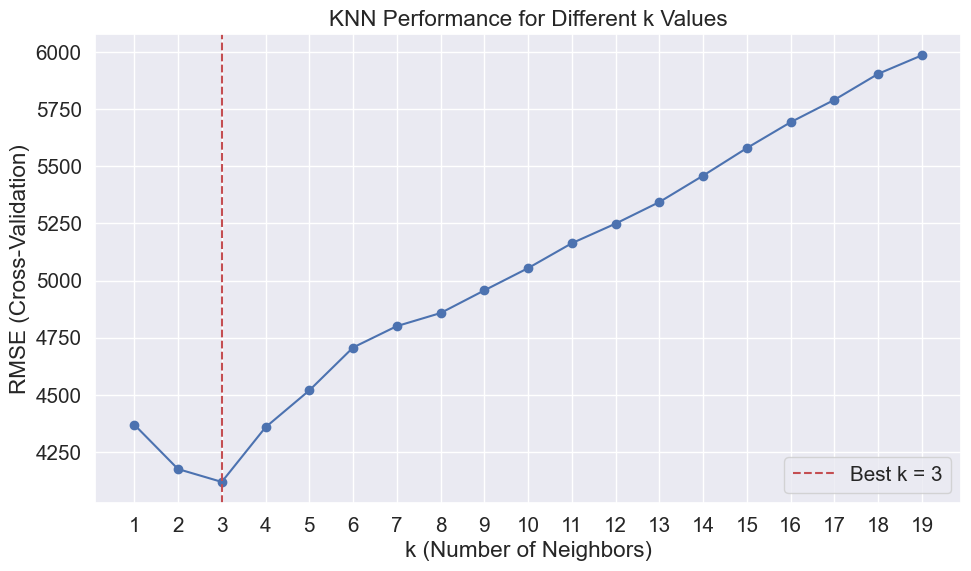

In [8]:
# Plot performance across different k values
cv_results = grid_search.cv_results_
k_values = param_grid['knn__n_neighbors']
mean_rmse = -cv_results['mean_test_score'] 

plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_rmse, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('RMSE (Cross-Validation)')
plt.title('KNN Performance for Different k Values')
plt.grid(True)
plt.xticks(k_values)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.legend()
plt.tight_layout()
plt.show()

The distances and the indices of the nearest K observations to each test observation can be obtained using the `kneighbors()` method.

In [9]:
# Get the KNN estimator from the pipeline
knn_estimator = best_model.named_steps['knn']

# Get indices of K-nearest neighbors for each test observation
neighbor_indices = knn_estimator.kneighbors(best_model.named_steps['preprocessor'].transform(X_test), 
                                           return_distance=False)
# neighbor_indices will contain the indices of the K nearest neighbors for each test observation
# Note: The indices are relative to the training set, not the test set.
# To get the actual neighbor observations, you can use these indices to index into the training set
# For example, to get the actual neighbor observations for the first test observation:
neighbors = X_train.iloc[neighbor_indices[0]]
neighbors

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
4580,merc,V Class,2010,Automatic,259000,Diesel,540,30.8345,3.0
5651,merc,CLK,2003,Automatic,185000,Petrol,330,18.0803,4.3
3961,vw,Caravelle,2006,Manual,178000,Diesel,325,34.5738,2.5


### Tuning Other KNN Hyperparameters

In addition to the number of neighbors (_k_), KNN has several other important hyperparameters that can significantly affect the model’s performance. Fine-tuning these settings helps you get the most out of the algorithm. Key hyperparameters include:

- **`weights`**: Determines how the neighbors contribute to the prediction.  
  - `'uniform'`: All neighbors are weighted equally (default).  
  - `'distance'`: Closer neighbors have more influence.  
  - Choosing `'distance'` can improve performance, especially when data points are unevenly distributed.

- **`metric`**: Defines the distance function used to measure similarity between data points.  
  - `'minkowski'` (default) is a general-purpose metric that includes both Euclidean and Manhattan distances.  
  - Other options include `'euclidean'`, `'manhattan'`, or even custom distance functions.

- **`p`**: Used when `metric='minkowski'`.  
  - `p=2` gives **Euclidean distance** (standard for continuous features).  
  - `p=1` gives **Manhattan distance** (useful when features are sparse or grid-based).  

- **`algorithm`**: Controls the method used to compute nearest neighbors.  
  - `'auto'`, `'ball_tree'`, `'kd_tree'`, or `'brute'`.  
  - Most users can leave this as `'auto'`, which lets scikit-learn choose the best algorithm based on the data.

These hyperparameters can be tuned using `GridSearchCV` to find the combination that yields the best performance on validation data.



The model hyperparameters can be obtained using the `get_params()` method. Note that there are other hyperparameters to tune in addition to number of neighbors. However, the number of neighbours may be the most influential hyperparameter in most cases.

In [10]:
# Get the best model parameters
best_model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num', 'passthrough',
                                    ['year', 'mileage', 'tax', 'mpg',
                                     'engineSize']),
                                   ('cat',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['brand', 'model', 'transmission',
                                     'fuelType'])])),
  ('scaler', StandardScaler()),
  ('knn', KNeighborsRegressor(n_neighbors=3))],
 'transform_input': None,
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('num', 'passthrough',
                                  ['year', 'mileage', 'tax', 'mpg',
                                   'engineSize']),
                                 ('cat',
                                  OneHotEncoder(handle_unknown='ignore',
                             

In [11]:
# Extended parameter grid
param_grid = {
    'knn__n_neighbors': list(range(1, 20, 2)),  # Test odd k values from 1 to 19 (step=2 for efficiency)
    'knn__weights': ['uniform', 'distance'],  # Uniform: equal weight; Distance: closer neighbors weigh more
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],  # Common distance metrics
    'knn__p': [1, 2]  # p=1 (Manhattan), p=2 (Euclidean) - only relevant for Minkowski
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',  # Optimize for RMSE
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit grid search
print("Tuning KNN hyperparameters...")
grid_search.fit(X_train, y_train)

# Get best parameters and results
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert negative RMSE to positive

# Display results
print("\nBest Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"Best CV RMSE: {best_score:.2f}")

# Evaluate on test set using best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_pred)  # Calculate RMSE
print(f"Test RMSE: {test_rmse:.2f}")

Tuning KNN hyperparameters...
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best Parameters:
knn__metric: euclidean
knn__n_neighbors: 3
knn__p: 1
knn__weights: distance
Best CV RMSE: 4001.34
Test RMSE: 3826.94


The results for each cross-validation are stored in the `cv_results_` attribute.

In [12]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__p,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.033124,0.003042,0.127347,0.023598,euclidean,1,1,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",-4656.637196,-3474.998033,-4250.919748,-4620.623046,-4839.806784,-4368.596961,485.981480,64
1,0.035615,0.010407,0.179835,0.013115,euclidean,1,1,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",-4656.637196,-3474.998033,-4250.919748,-4620.623046,-4839.806784,-4368.596961,485.981480,64
2,0.027877,0.002536,0.148597,0.018612,euclidean,1,2,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",-4656.637196,-3474.998033,-4250.919748,-4620.623046,-4839.806784,-4368.596961,485.981480,64
3,0.043631,0.016927,0.168392,0.027444,euclidean,1,2,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",-4656.637196,-3474.998033,-4250.919748,-4620.623046,-4839.806784,-4368.596961,485.981480,64
4,0.043071,0.009615,0.184532,0.042681,euclidean,3,1,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",-4227.667178,-3303.871045,-3851.430697,-4603.426146,-4600.719641,-4117.422942,492.858432,22


These results can be useful to see if other hyperparameter values are  equally good.

In [13]:
pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__p,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
87,0.038193,0.010690,0.149261,0.050225,minkowski,3,2,distance,"{'knn__metric': 'minkowski', 'knn__n_neighbors...",-4298.611714,-3197.944286,-3735.321059,-4407.722340,-4367.108381,-4001.341556,469.790238,1
5,0.047902,0.013181,0.185623,0.049865,euclidean,3,1,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",-4298.611714,-3197.944286,-3735.321059,-4407.722340,-4367.108381,-4001.341556,469.790238,1
7,0.040595,0.005817,0.132290,0.009807,euclidean,3,2,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",-4298.611714,-3197.944286,-3735.321059,-4407.722340,-4367.108381,-4001.341556,469.790238,1
51,0.034996,0.001900,0.744842,0.052065,manhattan,5,2,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",-4090.438714,-3258.873954,-3680.152758,-4846.570061,-4192.419206,-4013.690938,531.510686,4
49,0.031465,0.004676,0.718503,0.057517,manhattan,5,1,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",-4090.438714,-3258.873954,-3680.152758,-4846.570061,-4192.419206,-4013.690938,531.510686,4


The results show that the next two best hyperparameter values yield the same performance as the printed one

When dealing with a large number of possible hyperparameter values, using `GridSearchCV()` can become computationally expensive. In such cases, `RandomizedSearchCV()` offers a more efficient alternative by evaluating a randomly selected subset of hyperparameter combinations. The number of sampled combinations can be controlled by the user, making it suitable for situations with limited computational resources.

In addition to these methods, **`BayesSearchCV`**, based on Bayesian optimization, provides a more intelligent approach to hyperparameter tuning. It models the performance landscape and selects hyperparameter combinations to evaluate based on past results, often requiring fewer evaluations to find optimal or near-optimal values. This makes `BayesSearchCV` a powerful option, especially when training models is costly.


